In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from models_classif import EvenBinaryClassifier
import torch
import matplotlib.pyplot as plt
import matplotlib
from keras.datasets import mnist
from IPython.display import clear_output
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np

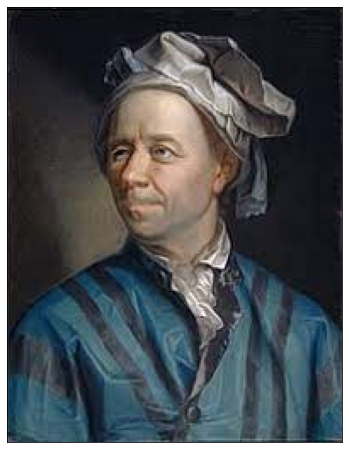

In [2]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

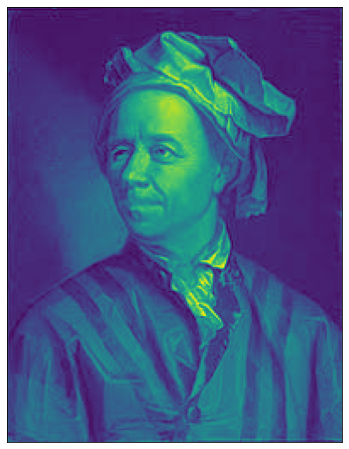

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(grey)
filename_png = 'euler_gray_scale.png'
figure.savefig(filename_png, bbox_inches='tight', pad_inches=0)

In [24]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 300000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)

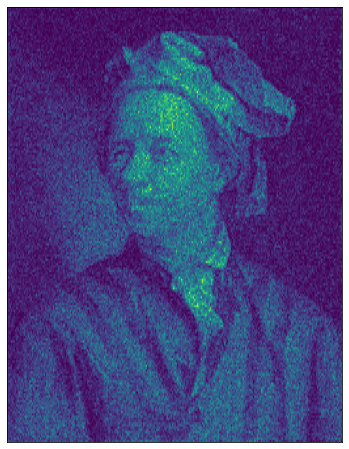

In [25]:
hist_target_samples, x_edges, y_edges = np.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [26]:
import torch
from torch import nn
from tqdm import tqdm

class Resampler(nn.Module):
    def __init__(self, label_1_samples, hidden_dims):
        super().__init__()
        
        cov = torch.cov(target_samples.T)
        self.instrumental = torch.distributions.MultivariateNormal(torch.mean(target_samples, dim = 0), 1/2*cov + 1/2*cov.T)

        self.label_1_samples = label_1_samples
        self.N = label_1_samples.shape[0]
        self.p = label_1_samples.shape[1]
        
        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1), nn.SiLU(), ])
        network.pop()
        self.logit_r = nn.Sequential(*network)

        self.loss_values=[]


    def loss(self, label_1_batch, label_0_batch):
        log_sigmoid = torch.nn.LogSigmoid()
        return -torch.mean(log_sigmoid(self.logit_r(label_1_batch)) + log_sigmoid(-self.logit_r(label_0_batch)))

    def log_density_ratio(self,x):
        return self.logit_r(x).squeeze(-1)
    
    def resample(self, number_proposed_samples):
        proposed_samples = self.instrumental.sample([number_proposed_samples])
        ratio = torch.exp(self.log_density_ratio(proposed_samples)).squeeze(-1)
        proba = ratio/torch.sum(ratio)
        pick = Categorical(proba).sample([number_proposed_samples])
        return(torch.stack([proposed_samples[pick[i], :] for i in range(number_proposed_samples)]))

    def train(self, epochs, batch_size = None, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        if batch_size is None:
            batch_size = self.label_1_samples.shape[0]
        dataset_1 = torch.utils.data.TensorDataset(self.label_1_samples)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=batch_size, shuffle=True)
            for batch_1 in dataloader_1:
                label_1_batch = batch_1[0].to(device)
                label_0_batch = self.instrumental.sample([label_1_batch.shape[0]]).to(device)
                optimizer.zero_grad()
                batch_loss = self.loss(label_1_batch,label_0_batch)
                batch_loss.backward()
                optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch_1[0].to(device),self.instrumental.sample([label_1_batch.shape[0]]).to(device)) for batch_1 in dataloader_1]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)))
        self.to(torch.device('cpu'))

In [31]:
resampler = Resampler(target_samples,[128,128,128,128])
resampler.train(100,6000)
samples = resampler.resample(300000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:59<00:00,  4.19s/it, loss = 1.235579]


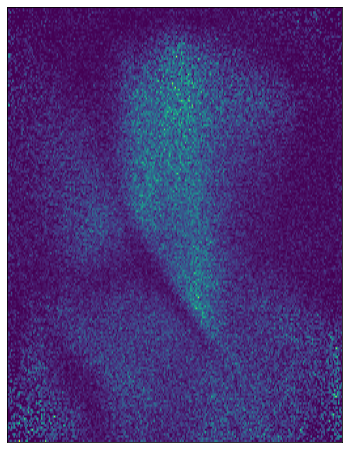

In [32]:
hist_samples, x_edges, y_edges = np.histogram2d(samples[:,1].numpy(), samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])